In [1]:
!pip -q install scikit-learn matplotlib pandas numpy
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

In [3]:
# --- 2) Train/validation split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [4]:
# --- 3) Build a pipeline: Standardize -> SVM ---
svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, random_state=42))
])

# --- 4) Quick baseline with default params ---
svm_pipe.fit(X_train, y_train)
y_pred = svm_pipe.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("\nBaseline Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Baseline Accuracy: 0.9473684210526315

Baseline Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.92      0.92      0.92        13
   virginica       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38



In [5]:
# --- 5) Hyperparameter search (GridSearchCV) ---
param_grid = {
    "svm__kernel": ["rbf", "linear"],
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.1, 0.01]  # only used when kernel="rbf"
}
grid = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=0,
)
grid.fit(X_train, y_train)

print("\nBest Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Best Params: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best CV Accuracy: 0.9644268774703557



Test Accuracy (Best Model): 0.9210526315789473

Classification Report (Best Model):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



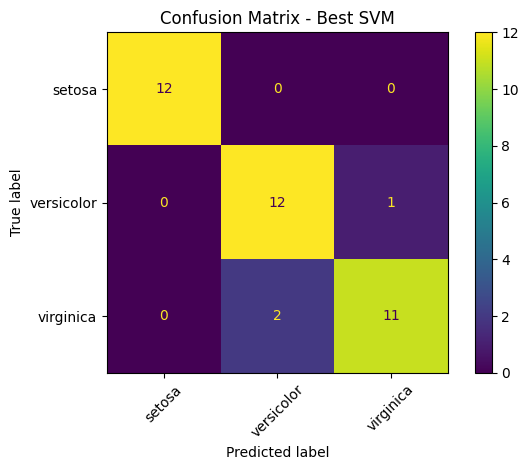

In [6]:
# --- 6) Evaluate best model ---
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
print("\nTest Accuracy (Best Model):", accuracy_score(y_test, y_pred_best))
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best, target_names=target_names))

# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_best, display_labels=target_names, xticks_rotation=45
)
plt.title("Confusion Matrix - Best SVM")
plt.tight_layout()
plt.show()

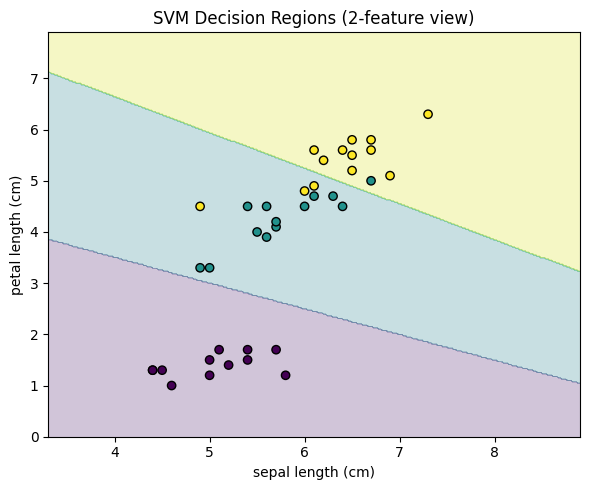

In [7]:
feat_idx = (0, 2)  # try (0,1), (0,2), (2,3), etc.
X2 = X[:, feat_idx]
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.25, random_state=42, stratify=y
)

viz_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel=grid.best_params_["svm__kernel"],
                C=grid.best_params_["svm__C"],
                gamma=grid.best_params_.get("svm__gamma", "scale"),
                probability=True,
                random_state=42))
])
viz_pipe.fit(X2_train, y2_train)

# create a mesh
x_min, x_max = X2[:,0].min() - 1, X2[:,0].max() + 1
y_min, y_max = X2[:,1].min() - 1, X2[:,1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
Z = viz_pipe.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, Z, alpha=0.25)
scatter = plt.scatter(X2_test[:,0], X2_test[:,1], c=y2_test, edgecolor="k")
plt.xlabel(iris.feature_names[feat_idx[0]])
plt.ylabel(iris.feature_names[feat_idx[1]])
plt.title("SVM Decision Regions (2-feature view)")
plt.tight_layout()
plt.show()
